In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import sys
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")

import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)
from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename

import src.src_current_measurement
importlib.reload(src.src_current_measurement);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, acquire_data, generate_ramp_beamsplitter_correlations_filename, generate_ramp_beamsplitter_correlations_clean_filename



In [2]:
def post_select_counts(measurement, readout_pair_1, readout_pair_2, post_select=True):
     ### plot post selected data

    counts = measurement.get_counts()
    times = measurement.get_times()

    num_qubits = measurement.get_num_qubits()
    num_particles = 4


    bitstrings = list(product([0,1], repeat=num_qubits))
    bitstrings_n_particles = []

    counts_n_particles = []
    for i, bitstring in enumerate(bitstrings):
        if sum(bitstring) == num_particles or not post_select:
            bitstrings_n_particles.append(bitstring)
            counts_n_particles.append(counts[i, :])

    counts_n_particles = np.array(counts_n_particles, dtype=float)
    counts_n_particles_average = np.array(counts_n_particles, dtype=float)

    for j in range(counts_n_particles_average.shape[-1]):
        counts_n_particles_average[:,j] = counts_n_particles_average[:,j] / np.sum(counts_n_particles_average[:,j])

    counts_n_particles_average = np.array(counts_n_particles, dtype=float)
    counts_n_particles_average /= np.sum(counts_n_particles_average, axis=0)

    
    populations_post_selected = np.zeros((num_qubits, counts_n_particles_average.shape[-1]))
    for i in range(len(bitstrings_n_particles)):
        for j in range(num_qubits):
            if bitstrings_n_particles[i][j] == 1:
                populations_post_selected[j, :] += counts_n_particles_average[i, :]

    total_population = np.sum(populations_post_selected, axis=0)

    population_differences_post_selected = np.zeros((4, counts_n_particles.shape[-1]))
    population_differences_post_selected[0, :] = populations_post_selected[readout_pair_1[1], :] - populations_post_selected[readout_pair_1[0], :]
    population_differences_post_selected[1, :] = populations_post_selected[readout_pair_2[1], :] - populations_post_selected[readout_pair_2[0], :]

    return populations_post_selected, counts_n_particles, bitstrings_n_particles, 


In [10]:
configuration_to_filename = {}


# 11/10/2025
configuration_to_filename['12-34-56-78'] = generate_ramp_double_jump_correlations_filename('2025', '11', '10', '17', '49', '57') 
# noisy to see swaps
# configuration_to_filename['12-34-56-78'] = generate_ramp_double_jump_correlations_filename('2025', '11', '10', '17', '45', '00') 

# 11/11/25
configuration_to_filename['12-34-56-78'] = generate_ramp_double_jump_correlations_filename('2025', '11', '11', '10', '35', '08') 
configuration_to_filename['1-23-45-67-8'] = generate_ramp_double_jump_correlations_filename('2025', '11', '11', '16', '04', '01') 
phase_parity_list = [-1,1,1,-1,1,1,1]

# 11/13/25
configuration_to_filename['1-23-45-67-8'] = generate_ramp_double_jump_correlations_filename('2025', '11', '13', '11', '22', '16') # low quality
configuration_to_filename['1-23-45-67-8'] = generate_ramp_double_jump_correlations_filename('2025', '11', '13', '13', '57', '01') # high quality


configuration_to_measurement = {}
for configuration in configuration_to_filename:
    configuration_to_measurement[configuration] = RampOscillationShotsMeasurement(configuration_to_filename[configuration])

In [11]:

measurement_configuration_even = '12-34-56-78'
measurement_configuration_odd = '1-23-45-67-8'

measurement_even = configuration_to_measurement[measurement_configuration_even]
measurement_odd = configuration_to_measurement[measurement_configuration_odd]

post_select = True

readout_pair_1 = (1,2)
readout_pair_2 = (3,4)

populations_post_selected_even, counts_n_particles_even, bitstrings_n_particles_even = post_select_counts(measurement_even, readout_pair_1, readout_pair_2, post_select=post_select)
populations_post_selected_odd, counts_n_particles_odd, bitstrings_n_particles_odd = post_select_counts(measurement_odd, readout_pair_1, readout_pair_2, post_select=post_select)

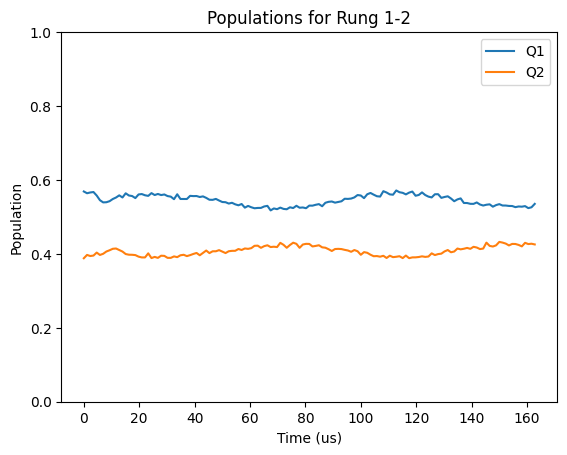

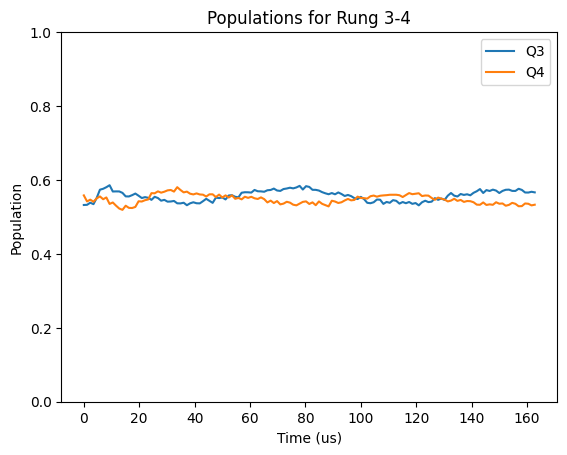

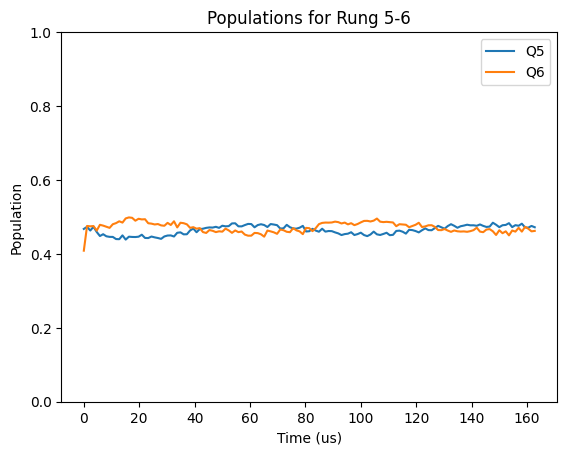

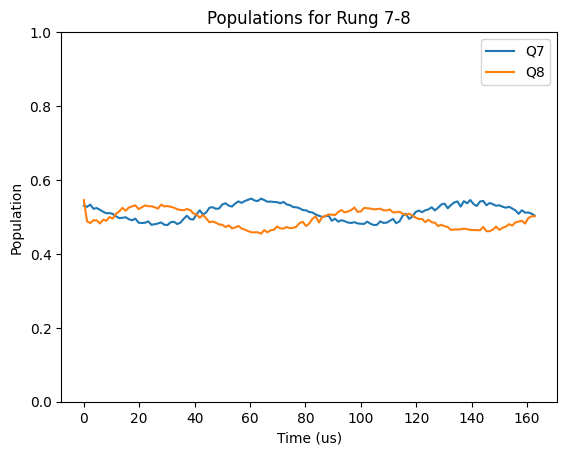

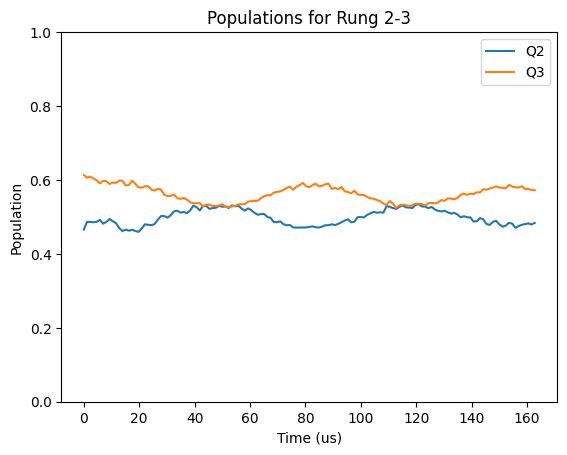

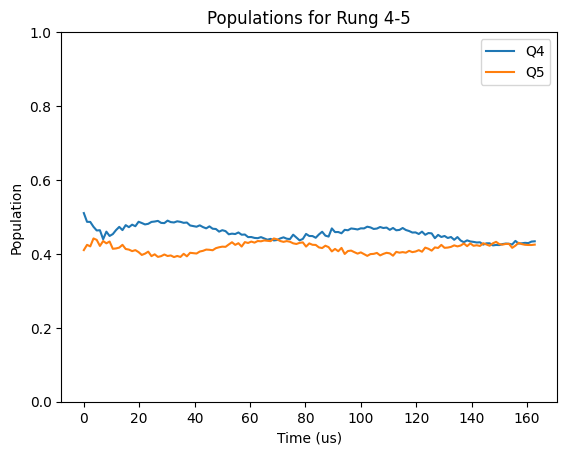

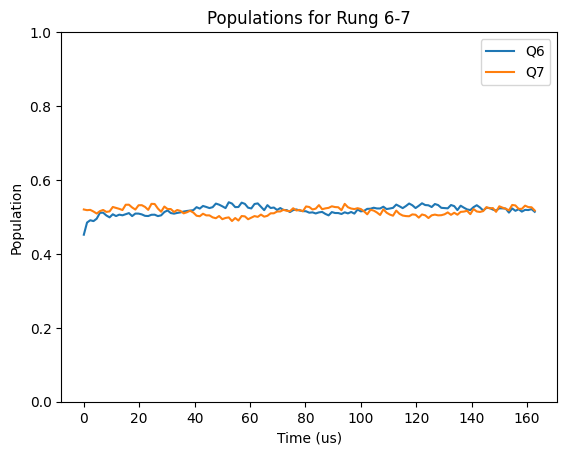

In [17]:
rungs_even = [(1,2),(3,4),(5,6),(7,8)]
rungs_odd = [(2,3),(4,5),(6,7)]

rungs = rungs_even + rungs_odd

times = measurement_even.get_times()

for rung in rungs:

    if rung in rungs_even:
        populations_post_selected = populations_post_selected_even
    else:
        populations_post_selected = populations_post_selected_odd

    plt.plot(times, populations_post_selected[rung[0]-1,:], label=f'Q{rung[0]}')
    plt.plot(times, populations_post_selected[rung[1]-1,:], label=f'Q{rung[1]}')
    plt.xlabel('Time (us)')
    plt.ylabel('Population')
    plt.title(f'Populations for Rung {rung[0]}-{rung[1]}')
    plt.legend()

    plt.ylim(0,1)

    plt.show()


In [18]:
beamsplitter_time_default = 20  # in ns

rung_to_beamsplitter_time = {}

rung_to_beamsplitter_time[(1,2)] = beamsplitter_time_default + 6
rung_to_beamsplitter_time[(2,3)] = beamsplitter_time_default
rung_to_beamsplitter_time[(3,4)] = beamsplitter_time_default + 18
rung_to_beamsplitter_time[(4,5)] = beamsplitter_time_default + 8
rung_to_beamsplitter_time[(5,6)] = beamsplitter_time_default
rung_to_beamsplitter_time[(6,7)] = beamsplitter_time_default
rung_to_beamsplitter_time[(7,8)] = beamsplitter_time_default + 5

0 1
2 3
4 5
6 7
1 2
3 4
5 6


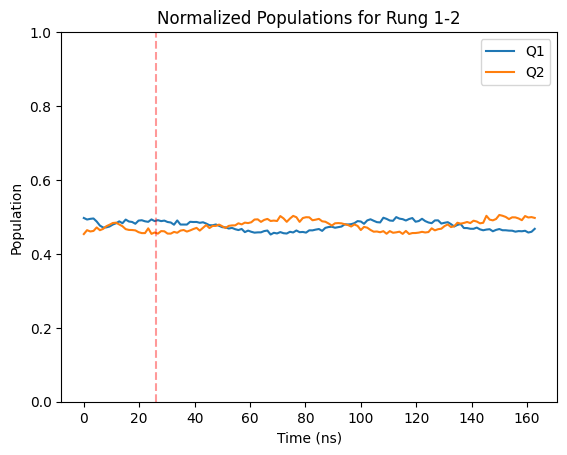

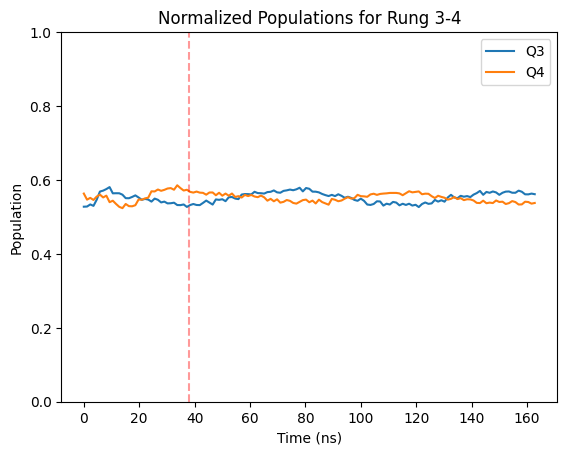

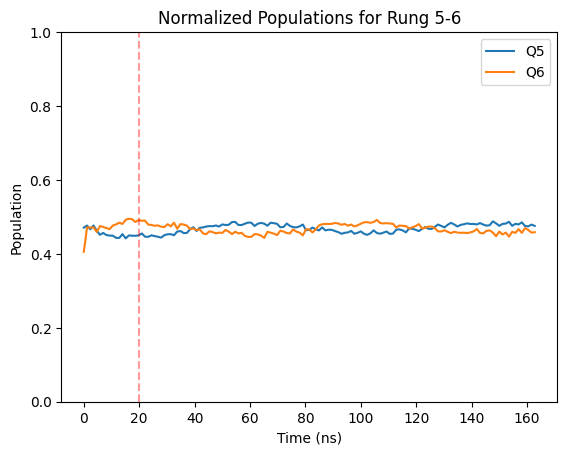

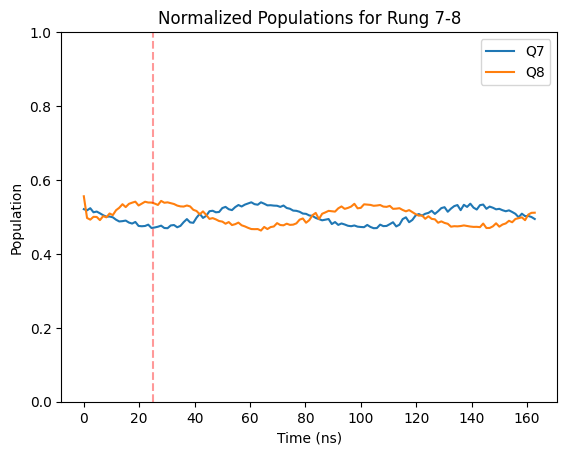

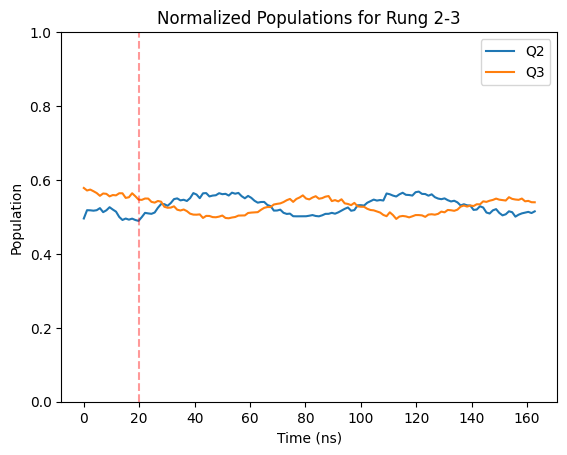

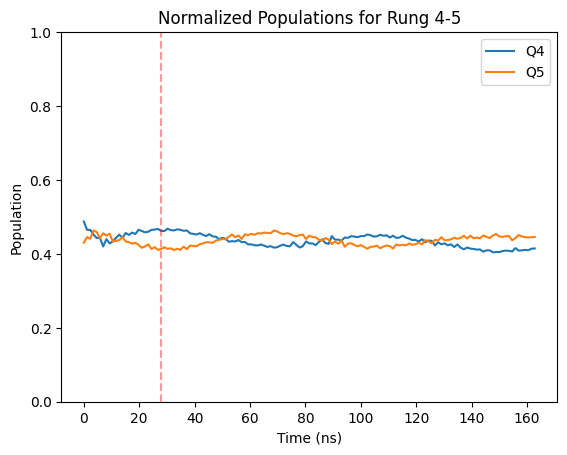

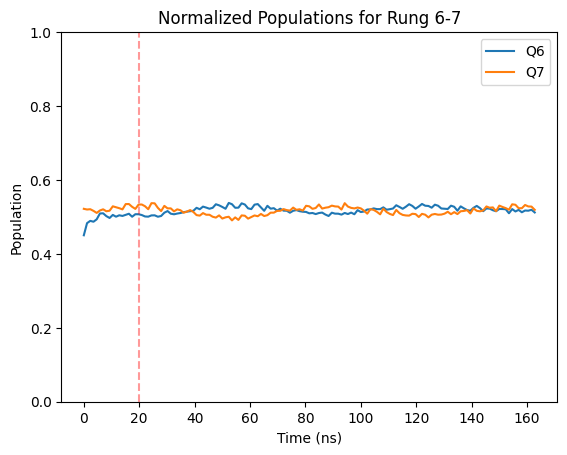

In [19]:
populations_normalized_even = np.zeros_like(populations_post_selected_even)
populations_normalized_odd = np.zeros_like(populations_post_selected_odd)

for rung in rungs:


    if rung in rungs_even:
        populations_post_selected = populations_post_selected_even
        populations_normalized = populations_normalized_even
    elif rung in rungs_odd:
        populations_post_selected = populations_post_selected_odd
        populations_normalized = populations_normalized_odd
    else:
        continue

    i = rung[0] - 1
    j = rung[1] - 1

    print(i,j)

    mean_i = populations_post_selected[i].mean()
    mean_j = populations_post_selected[j].mean()
    target = 0.5 * (mean_i + mean_j)

    if mean_i > 0:
        populations_normalized[i] = populations_post_selected[i] * (target / mean_i)
    else:
        populations_normalized[i] = populations_post_selected[i].copy()

    if mean_j > 0:
        populations_normalized[j] = populations_post_selected[j] * (target / mean_j)
    else:
        populations_normalized[j] = populations_post_selected[j].copy()
    


times = measurement_even.get_times()

for rung in rungs:

    if rung in rungs_even:
        populations_normalized = populations_normalized_even
    elif rung in rungs_odd:
        populations_normalized = populations_normalized_odd
    else:
        continue


    plt.plot(times, populations_normalized[rung[0]-1,:], label=f'Q{rung[0]}')
    plt.plot(times, populations_normalized[rung[1]-1,:], label=f'Q{rung[1]}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Population')
    plt.title(f'Normalized Populations for Rung {rung[0]}-{rung[1]}')
    plt.legend()

    beamsplitter_time = rung_to_beamsplitter_time[rung]
    plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

    plt.ylim(0,1)

    plt.show()



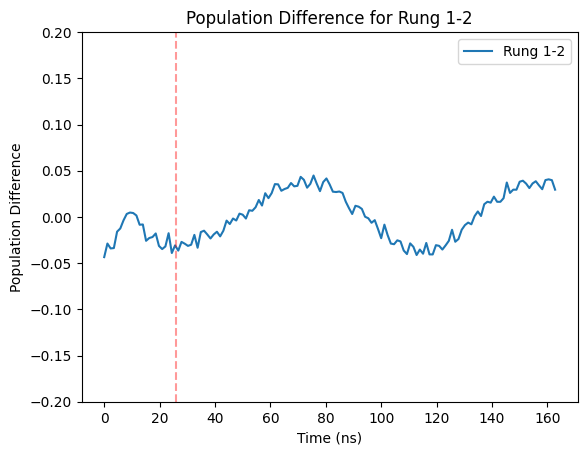

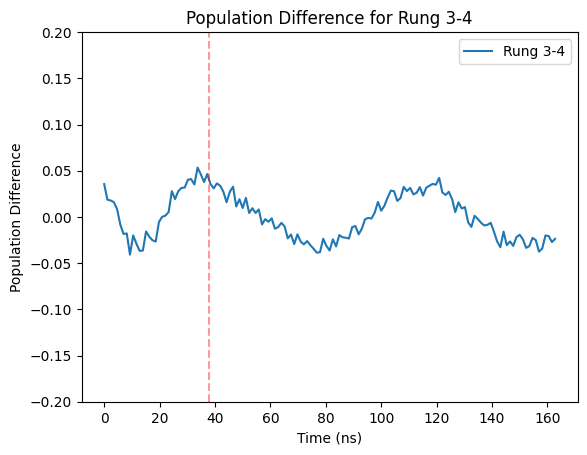

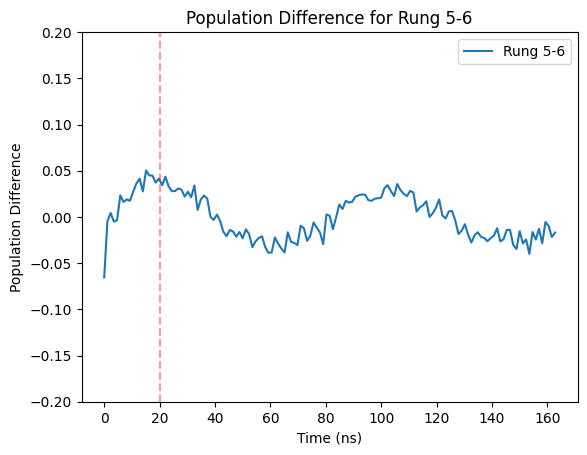

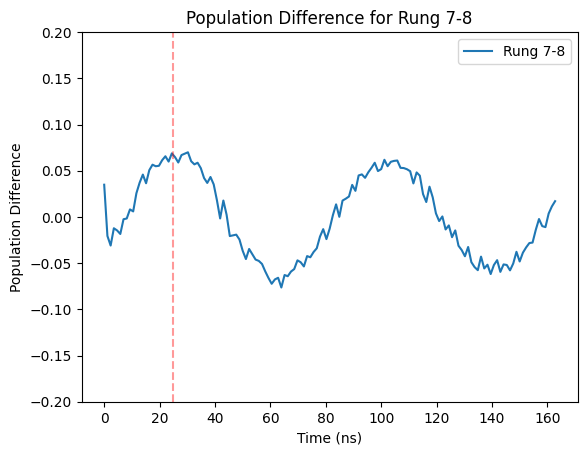

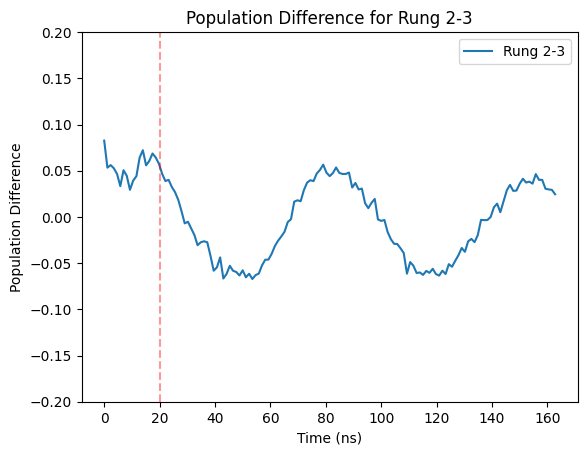

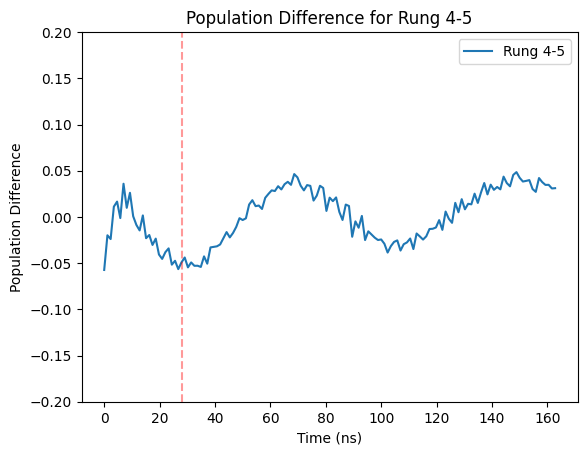

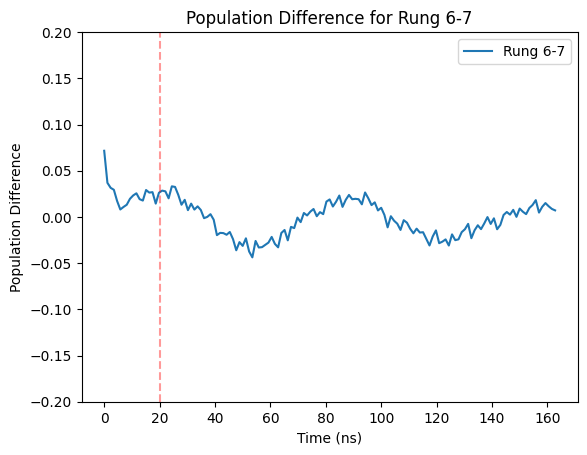

In [20]:
### plot population differences

rung_to_population_difference = {}

for rung in rungs:

    if rung in rungs_even:
        populations_normalized = populations_normalized_even
    elif rung in rungs_odd:
        populations_normalized = populations_normalized_odd
    else:
        continue

    population_difference = populations_normalized[rung[1]-1,:] - populations_normalized[rung[0]-1,:]
    rung_to_population_difference[rung] = population_difference

    plt.plot(times, population_difference, label=f'Rung {rung[0]}-{rung[1]}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Population Difference')
    plt.title(f'Population Difference for Rung {rung[0]}-{rung[1]}')
    plt.legend()

    beamsplitter_time = rung_to_beamsplitter_time[rung]
    plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

    plt.ylim(-0.2,0.2)

    plt.show()

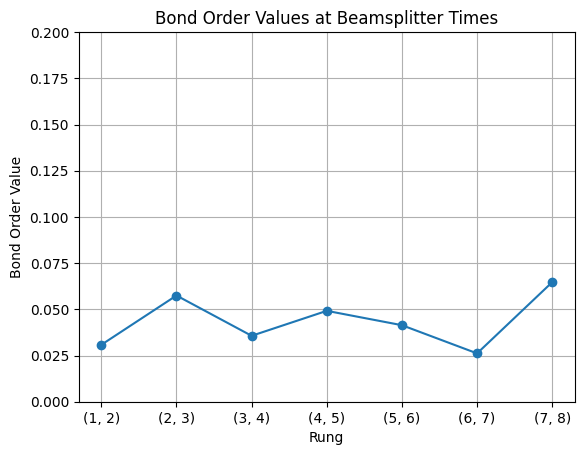

In [21]:
### extract value at beamsplitter time

bond_order_values = []

rungs_ordered = sorted(rungs, key=lambda x: x[0])

for rung in rungs_ordered:

    beamsplitter_time = rung_to_beamsplitter_time[rung]
    time_index = np.argmin(np.abs(times - beamsplitter_time))

    if not rung in rung_to_population_difference:
        continue

    population_difference = rung_to_population_difference[rung]

    bond_order_value = population_difference[time_index]

    rung_qubit_index = rung[0] - 1
    phase_parity = phase_parity_list[rung_qubit_index]

    bond_order_value *= phase_parity

    bond_order_values.append(bond_order_value)

plt.plot(range(1, len(bond_order_values)+1), bond_order_values, marker='o')



plt.xlabel('Rung')
plt.ylabel('Bond Order Value')
plt.title('Bond Order Values at Beamsplitter Times')
plt.xticks(range(1, len(bond_order_values)+1), [str(rung) for rung in rungs_ordered])
plt.ylim(-0.2, 0.2)
plt.ylim(0, 0.2)
plt.grid()
plt.show()